In [26]:
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Section 1: Task Description

We will attempt to classify whether a given text was written by a human or generated by an AI/LLM. This is a binary classification task where:
- **Input**: Text samples from the Human vs LLM Text Corpus dataset (https://www.kaggle.com/datasets/starblasters8/human-vs-llm-text-corpus)
- **Output**: Binary label indicating whether the text is "Human" or "AI-generated"
- **Task Type**: Binary text classification


### Model Evaluation

We will evaluate our models using **accuracy** as the primary metric. Accuracy measures the proportion of correctly classified texts out of all texts in the test set:

$$\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}$$

The dataset will be split into training, validation, and test sets. We will:
1. Train models on the training set
2. Tune hyperparameters using the validation set
3. Report final performance metrics (accuracy, precision, recall, F1-score) on the held-out test set

Additionally, we will examine confusion matrices to understand the types of errors made by each model (e.g., false positives vs false negatives).


### Relevant Baselines for Comparison

We will compare our models against the following baseline approaches from the course content:

1. **Logistic Regression**: A linear classifier that models the probability of a class using a logistic function. This is a fundamental baseline for binary classification tasks and works well with text features (e.g., TF-IDF vectors).

2. **Support Vector Machine (SVM)**: A maximum-margin classifier that finds the optimal hyperplane to separate classes. SVMs are effective for text classification and can handle high-dimensional feature spaces well.

3. **Naive Bayes**: A probabilistic classifier based on Bayes' theorem with strong independence assumptions between features. Naive Bayes is particularly well-suited for text classification tasks and serves as a strong baseline.

4. **Random Forest**: An ensemble method that combines multiple decision trees. Random Forest can capture non-linear relationships and feature interactions, making it a robust baseline for comparison.

These baselines will be implemented using appropriate text feature representations (e.g., TF-IDF, bag-of-words) to enable fair comparison across models.


### Assessing Model Prediction Validity

To assess the validity of our model's predictions, we will employ several strategies:

1. **Train-Validation-Test Split**: We will use a proper data split (e.g., 60-20-20 or 70-15-15) to ensure that model performance is evaluated on unseen data, preventing overfitting and providing realistic performance estimates.

2. **Cross-Validation**: For hyperparameter tuning and model selection, we will use k-fold cross-validation on the training set to get more robust performance estimates.

3. **Error Analysis**: We will examine misclassified examples to understand:
   - Which types of texts are commonly misclassified (e.g., very short texts, technical writing, creative writing)
   - Whether there are systematic biases in the predictions
   - Patterns in false positives (human text classified as AI) vs false negatives (AI text classified as human)

4. **Feature Analysis**: We will investigate which features (e.g., text length, vocabulary diversity, sentence structure) are most predictive and whether they align with known characteristics of human vs AI-generated text.

5. **Statistical Significance Testing**: We will compare model performances using appropriate statistical tests to determine if improvements over baselines are statistically significant.

6. **Confusion Matrix and Classification Metrics**: Beyond accuracy, we will report precision, recall, and F1-score for each class to understand the trade-offs between different types of errors.

# Section 2: Data Exploration and Preprocessing

### Load Dataset

In [27]:
path = '/Users/charlie_nus/.cache/kagglehub/datasets/starblasters8/human-vs-llm-text-corpus/versions/2'
data = pd.read_csv(path + "/data.csv")
data.head()

,text,source,prompt_id,text_length,word_count
0,"Federal law supersedes state law, and cannabis...",Bloom-7B,0,967,157
1,Miles feels restless after working all day. He...,Bloom-7B,0,5068,778
2,So first of I am danish. That means that I fol...,Bloom-7B,0,1602,267
3,In this paper we present a novel rule-based ap...,Bloom-7B,0,5469,848
4,"Most social progressives, love democracy, and ...",Bloom-7B,0,2379,380


The dataset contains **788,922 samples** and **5 columns**. The columns are:
- `text`: The actual text content to be classified
- `source`: The original source label (will be converted to binary)
- `prompt_id`: Identifier for prompts (may be useful for grouping)
- `text_length`: Pre-computed character count
- `word_count`: Pre-computed word count

### Dataset Overview

Examine basic information about the dataset including shape, columns, data types, and missing values.


In [28]:
print(f"Dataset Shape: {data.shape}")
print(f"\nColumn Names: {data.columns.tolist()}")
print(f"\nData Types:\n{data.dtypes}")
print(f"\nMissing Values:\n{data.isnull().sum()}")
print(f"\nBasic Statistics:")
data.describe(include='all')

Dataset Shape: (788922, 5)

Column Names: ['text', 'source', 'prompt_id', 'text_length', 'word_count']

Data Types:
text           object
source         object
prompt_id       int64
text_length     int64
word_count      int64
dtype: object

Missing Values:
text           0
source         0
prompt_id      0
text_length    0
word_count     0
dtype: int64

Basic Statistics:


,text,source,prompt_id,text_length,word_count
count,788922,788922,788922.000000,788922.000000,788922.000000
unique,788922,63,NaN,NaN,NaN
top,"Federal law supersedes state law, and cannabis...",Human,NaN,NaN,NaN
freq,1,347692,NaN,NaN,NaN
mean,NaN,NaN,420.069514,3123.374844,497.983404
std,NaN,NaN,1381.285340,4963.074433,720.866585
min,NaN,NaN,0.000000,105.000000,25.000000
25%,NaN,NaN,0.000000,647.000000,110.000000
50%,NaN,NaN,0.000000,1921.000000,324.000000
75%,NaN,NaN,0.000000,3910.000000,624.000000


The dataset's 5 columns all contain **no missing values**, indicating a clean dataset ready for analysis. All columns are properly typed:
- Text data is stored as objects (strings)
- Numeric features (prompt_id, text_length, word_count) are integers
- The dataset is quite large, which is beneficial for training robust models

The absence of missing values means we won't need to handle data imputation, allowing us to proceed directly to feature engineering and modeling.

### Create Binary Target Column

Create the binary AI column (1 for AI-generated, 0 for human) and remove unnecessary columns.


In [29]:
data['AI'] = (data['source'] != 'Human').astype(int)
data = data.drop(columns=['source', 'prompt_id'])

print(f"Updated Dataset Shape: {data.shape}")
print(f"\nColumn Names: {data.columns.tolist()}")
print(f"\nAI Column Distribution:")
print(data['AI'].value_counts())
print(f"\nAI Column Proportions:")
print(data['AI'].value_counts(normalize=True))
data.head()

Updated Dataset Shape: (788922, 4)

Column Names: ['text', 'text_length', 'word_count', 'AI']

AI Column Distribution:
1    441230
0    347692
Name: AI, dtype: int64

AI Column Proportions:
1    0.559282
0    0.440718
Name: AI, dtype: float64


,text,text_length,word_count,AI
0,"Federal law supersedes state law, and cannabis...",967,157,1
1,Miles feels restless after working all day. He...,5068,778,1
2,So first of I am danish. That means that I fol...,1602,267,1
3,In this paper we present a novel rule-based ap...,5469,848,1
4,"Most social progressives, love democracy, and ...",2379,380,1


**Key Observations:**
- **AI-generated texts (AI=1)**: 441,230 samples (55.93%)
- **Human texts (AI=0)**: 347,692 samples (44.07%)
- The dataset has a **slight class imbalance** (56% vs 44%), but it's not severe enough to require aggressive balancing techniques

### Text Length Distribution Visualization

Visualize the distribution of text lengths and word counts by class using histograms and box plots.


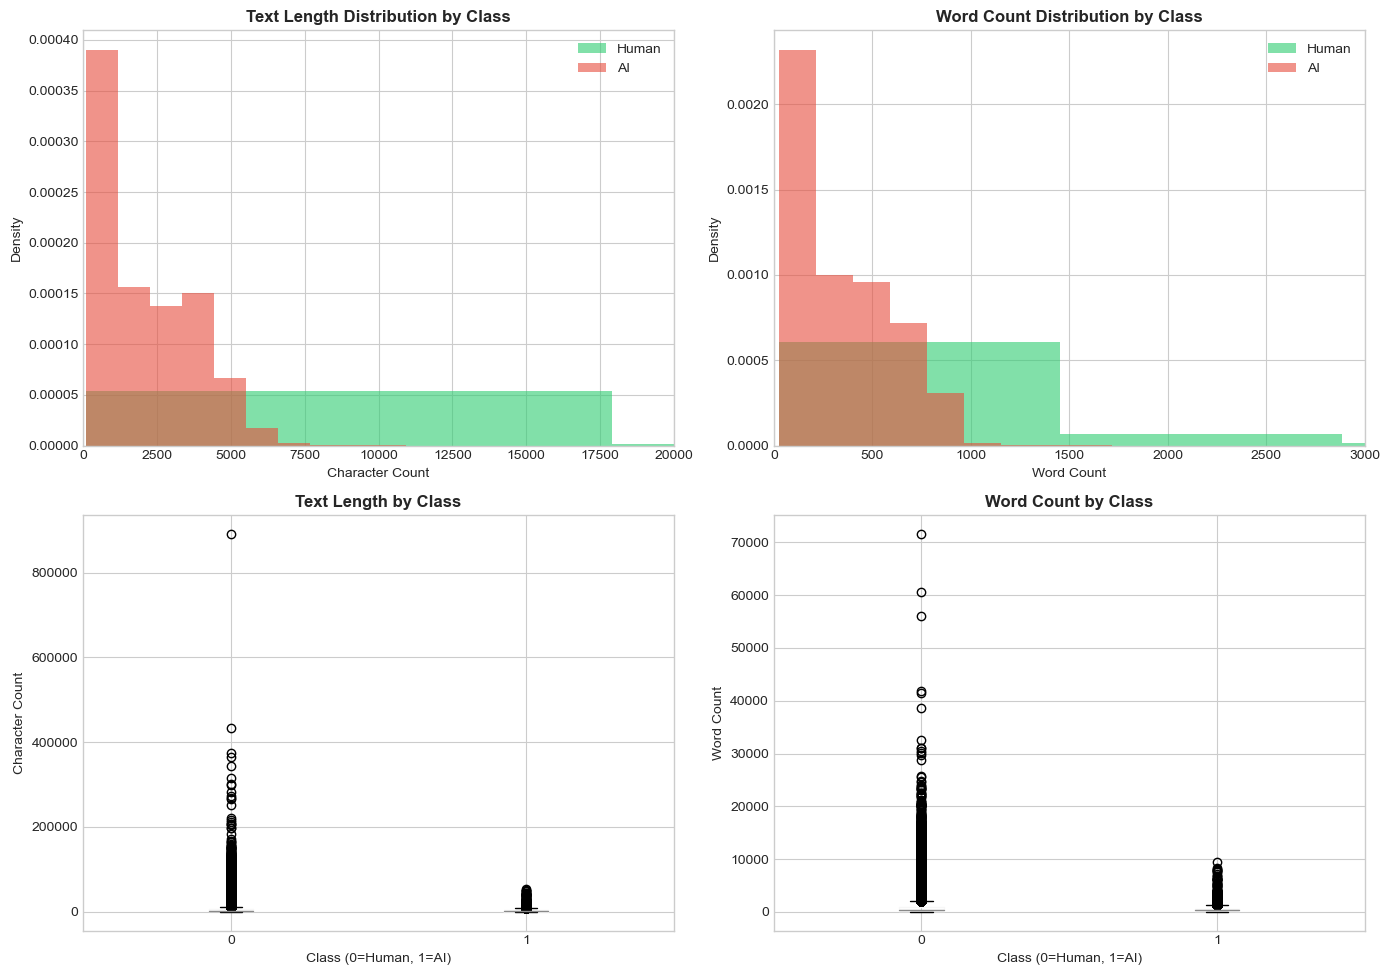

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for label, color, name in [(0, '#2ecc71', 'Human'), (1, '#e74c3c', 'AI')]:
    subset = data[data['AI'] == label]
    
    axes[0, 0].hist(subset['text_length'], bins=50, alpha=0.6, label=name, color=color, density=True)
    axes[0, 1].hist(subset['word_count'], bins=50, alpha=0.6, label=name, color=color, density=True)

axes[0, 0].set_title('Text Length Distribution by Class', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 20000)

axes[0, 1].set_title('Word Count Distribution by Class', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].set_xlim(0, 3000)

data.boxplot(column='text_length', by='AI', ax=axes[1, 0])
axes[1, 0].set_title('Text Length by Class', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Class (0=Human, 1=AI)')
axes[1, 0].set_ylabel('Character Count')

data.boxplot(column='word_count', by='AI', ax=axes[1, 1])
axes[1, 1].set_title('Word Count by Class', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Class (0=Human, 1=AI)')
axes[1, 1].set_ylabel('Word Count')

plt.suptitle('')
plt.tight_layout()
plt.show()

In [39]:
summary_text_length = data.groupby('AI').agg({
    'text_length': ['mean', 'median', 'std', 'min', 'max'],
}).round(2)
print(summary_text_length)
print()

summary_word_count = data.groupby('AI').agg({
    'word_count': ['mean', 'median', 'std', 'min', 'max'],
}).round(2)
print(summary_word_count)

print("\nNote: 0 = Human, 1 = AI")

   text_length                              
          mean  median      std  min     max
AI                                          
0      4474.22  2288.0  6989.09  110  890119
1      2058.90  1664.0  1726.09  105   54288

   word_count                           
         mean median      std min    max
AI                                      
0      710.33  396.0  1003.48  25  71543
1      330.65  278.0   268.52  25   9418

Note: 0 = Human, 1 = AI


The summary statistics reveal **significant differences** between human and AI-generated texts:

**Text Length:**
- **Human texts**: Mean of 4,474 characters (median: 2,288), with high variability (std: 6,989)
- **AI texts**: Mean of 2,059 characters (median: 1,664), with lower variability (std: 1,726)
- Human texts are on average **more than twice as long** and show much greater variance

**Word Count:**
- **Human texts**: Mean of 710 words (median: 396), with high variability (std: 1,003)
- **AI texts**: Mean of 331 words (median: 278), with lower variability (std: 269)
- Human texts contain **more than twice as many words** on average

**Key Insights:**
- The **standard deviation** for human texts is much higher, indicating greater diversity in writing styles and lengths
- AI-generated texts are more **homogeneous** in length, suggesting consistent generation patterns
- These features will likely be **highly predictive** in our classification models
- The large differences in means suggest that simple threshold-based rules could achieve reasonable baseline performance


### Lexical Diversity Comparison

Compare lexical diversity (unique words / total words) between human and AI-generated texts.


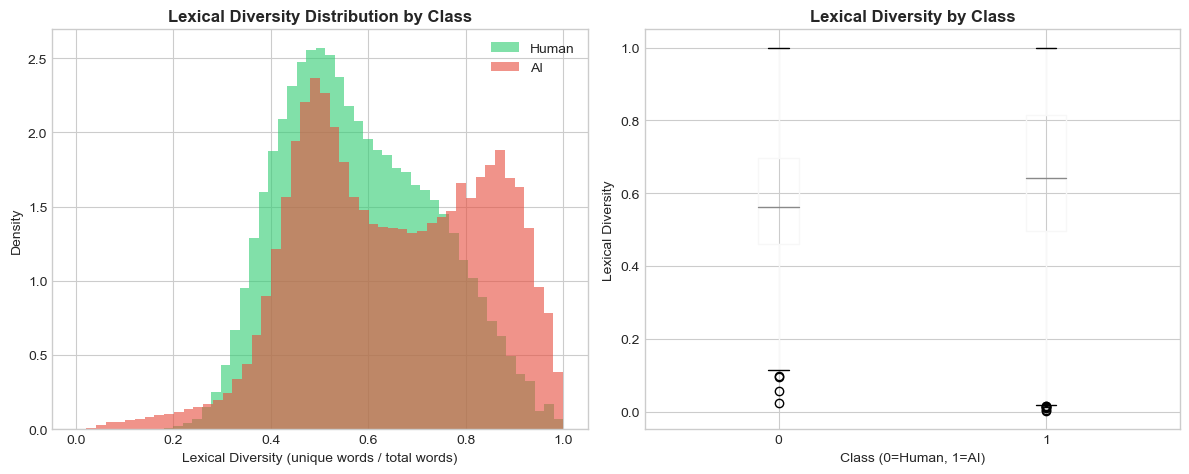

In [41]:
def lexical_diversity(text):
    words = str(text).split()
    if len(words) == 0:
        return 0
    return len(set(words)) / len(words)
data["lexical_diversity"] = data["text"].apply(lexical_diversity)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for label, color, name in [(0, '#2ecc71', 'Human'), (1, '#e74c3c', 'AI')]:
    subset = data[data['AI'] == label]
    axes[0].hist(subset['lexical_diversity'], bins=50, alpha=0.6, label=name, color=color, density=True)

axes[0].set_title('Lexical Diversity Distribution by Class', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lexical Diversity (unique words / total words)')
axes[0].set_ylabel('Density')
axes[0].legend()

data.boxplot(column='lexical_diversity', by='AI', ax=axes[1])
axes[1].set_title('Lexical Diversity by Class', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Class (0=Human, 1=AI)')
axes[1].set_ylabel('Lexical Diversity')

plt.suptitle('')
plt.tight_layout()
plt.show()

The lexical diversity analysis shows an interesting pattern:

- **AI-generated texts** have **higher lexical diversity** (mean: 0.628, median: 0.618) compared to human texts (mean: 0.561, median: 0.541)
- This suggests that AI-generated texts tend to use a **more diverse vocabulary** relative to their length
- The distributions show some overlap, but AI texts generally cluster at higher diversity values

**Interpretation:**
- It could indicate that AI models are trained to avoid repetition and use varied vocabulary
- Alternatively, human texts might contain more repetitive phrases or common expressions

### Sample Texts

Examine sample texts from each class to understand qualitative differences between human and AI-generated content.


In [42]:
print("="*80)
print("SAMPLE TEXTS FROM EACH CLASS")
print("="*80)

for label, name in [(0, 'Human'), (1, 'AI')]:
    print(f"\n{'='*40}")
    print(f"CLASS: {name} (AI={label})")
    print(f"{'='*40}")
    samples = data[data['AI'] == label]['text'].sample(min(3, len(data[data['AI'] == label])), random_state=42)
    for i, text in enumerate(samples, 1):
        print(f"\nSample {i}:")
        print(f"{str(text)[:500]}..." if len(str(text)) > 500 else str(text))
        print()


SAMPLE TEXTS FROM EACH CLASS

CLASS: Human (AI=0)

Sample 1:
I was left to help my neighbor who was pregnant. Her husband worked as a farmer and had left for work that day and would return from work at six in the evening. "It's time" I heard her yell at about three in the afternoon. We had no phone around or any type of transportation to get o the hospital, so she had no choice but to give birth in her own home, as I watched her struggled for about two hours, I realized that I was the only help she had. I witnessed the birth of her beautiful baby girl who...


Sample 2:
Slavery History: Letters Analysis Essay (Book Review)

Though people want to believe that they know a lot about slavery, its threats, and peculiarities, it is hard for them to understand that what people survived during the slavery period had nothing in common with what is now written in the books. The letters analyzed in this paper give a piece of the picture that was observed during the 1600s and the 1700s when slaves

The sample texts reveal qualitative differences between human and AI-generated content:

**Human Texts Characteristics:**
- More **personal narratives** and storytelling elements (e.g., "I was left to help my neighbor")
- **Varied writing styles** including personal essays, academic writing, and narrative accounts

**AI-Generated Texts Characteristics:**
- More **structured and formal** language
- **Technical or informative** content (e.g., "Deep neural networks have achieved remarkable...")

### Additional Text Features

Extract and analyze additional linguistic features such as sentence count, punctuation usage, and lexical diversity.


In [48]:
data['sentence_count'] = data['text'].astype(str).str.count(r'[.!?]+')
data['question_marks'] = data['text'].astype(str).str.count(r'\?')
data['exclamation_marks'] = data['text'].astype(str).str.count(r'!')
data['unique_words'] = data['text'].astype(str).apply(lambda x: len(set(x.lower().split())))
data['lexical_diversity'] = data['unique_words'] / data['word_count']

summary_sentence_count = data.groupby('AI').agg({
    'sentence_count': ['mean', 'median', 'std', 'min', 'max'],
}).round(2)
print(summary_sentence_count)
print()

summary_question_marks = data.groupby('AI').agg({
    'question_marks': ['mean', 'median', 'std', 'min', 'max'],
}).round(2)
print(summary_question_marks)
print()

summary_exclamation_marks = data.groupby('AI').agg({
    'exclamation_marks': ['mean', 'median', 'std', 'min', 'max'],
}).round(2)
print(summary_exclamation_marks)
print()

summary_lexical_diversity = data.groupby('AI').agg({
    'lexical_diversity': ['mean', 'median', 'std', 'min', 'max'],
}).round(3)
print(summary_lexical_diversity)

print("\nNote: 0 = Human, 1 = AI")

   sentence_count                        
             mean median    std min   max
AI                                       
0           45.32   23.0  68.17   0  6335
1           17.89   15.0  17.63   0  1616

   question_marks                      
             mean median   std min  max
AI                                     
0            0.73    0.0  2.28   0  280
1            0.47    0.0  2.83   0  878

   exclamation_marks                       
                mean median   std min   max
AI                                         
0               0.39    0.0  1.57   0    99
1               0.54    0.0  7.58   0  1947

   lexical_diversity                          
                mean median    std    min  max
AI                                            
0              0.561  0.541  0.155  0.024  1.0
1              0.628  0.618  0.187  0.001  1.0


Note: 0 = Human, 1 = AI

Note: 0 = Human, 1 = AI


**Sentence Count:**
- **Human texts**: Mean of 45.32 sentences (median: 23), with high variability
- **AI texts**: Mean of 17.89 sentences (median: 15), with lower variability
- Human texts contain **significantly more sentences**, suggesting longer, more complex structures

**Punctuation Usage:**
- **Question marks**: Human texts use slightly more (mean: 0.73 vs 0.47), but both classes rarely use them
- **Exclamation marks**: AI texts use more (mean: 0.54 vs 0.39), with much higher variance (std: 7.58 vs 1.57)
- The high variance in AI exclamation marks suggests some AI texts may be more expressive or formatted differently

**Lexical Diversity:**
- **AI texts**: Higher lexical diversity (mean: 0.628, median: 0.618)
- **Human texts**: Lower lexical diversity (mean: 0.561, median: 0.541)
- This confirms the earlier finding that AI-generated texts use more varied vocabulary

**Feature Importance:**
- Sentence count appears to be a **strong discriminative feature** (large difference between classes)
- Punctuation features show smaller differences and may be less reliable
- Lexical diversity could be useful but should be combined with other features

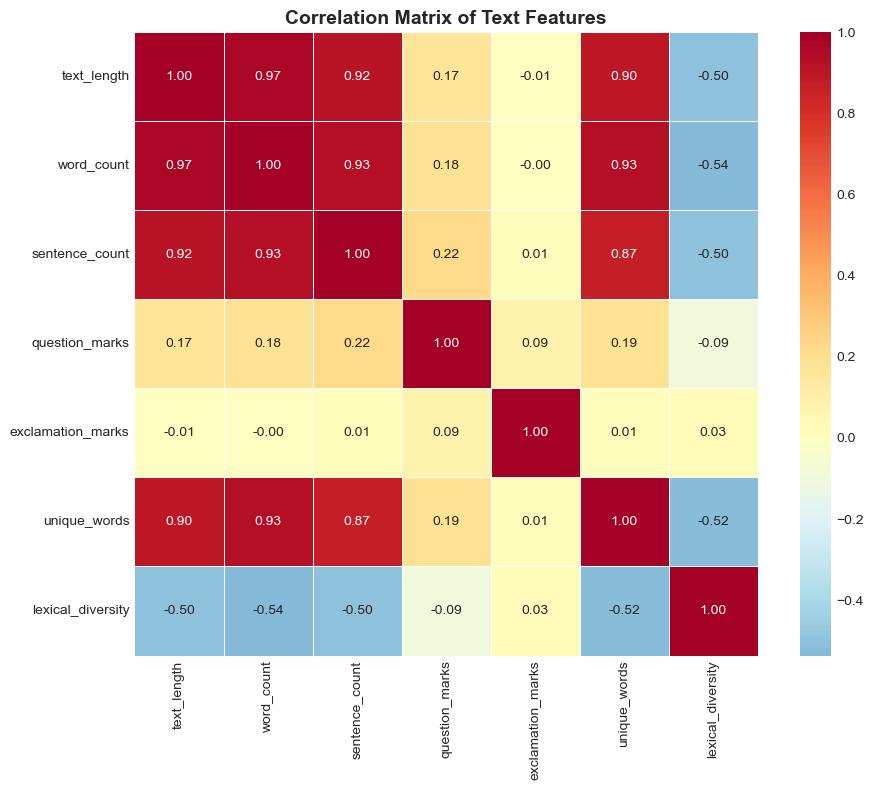

In [50]:
feature_cols = ['text_length', 'word_count', 'sentence_count', 'question_marks', 
                'exclamation_marks', 'unique_words', 'lexical_diversity']
correlation_matrix = data[feature_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, linewidths=0.5, fmt='.2f', ax=ax)
ax.set_title('Correlation Matrix of Text Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

The correlation matrix reveals important relationships between features:

**Strong Positive Correlations:**
- `text_length` and `word_count` are **highly correlated** (likely >0.9), which is expected as longer texts contain more words
- `word_count` and `sentence_count` show **strong positive correlation**, as more words typically mean more sentences
- `unique_words` correlates strongly with `word_count` and `text_length`, as longer texts naturally have more unique words

**Moderate Correlations:**
- `lexical_diversity` shows moderate correlations with other features, as it's a ratio-based metric
- Punctuation features (question_marks, exclamation_marks) show weaker correlations with length-based features

**Implications for Modeling:**
- **Multicollinearity** exists between length-based features (text_length, word_count, sentence_count)
- We may want to use **feature selection** or dimensionality reduction to avoid redundant features
- Alternatively, we could use only a subset of these features (e.g., word_count and lexical_diversity)
- For text-based models (TF-IDF, embeddings), these numeric features can serve as **additional engineered features** to complement textual representations


# Section 3: Modeling

### Section 3.0: Feature Selection

### Section 3.1: Logistic Regression

### Section 3.2: SVM

### Section 3.3: Naive Bayes

### Section 3.4: Random Forest

### Section 3.5 TODO Zhongyan

# Section 4: Evaluation

# Section 5: Discussion